**Бустинг**

Бустинг (boosting) – это ансамблевый метод, в котором так же, как и в бэггинге и случайных лесах, строится множество базовых алгоритмов из одного семейства, объединяющихся затем в более сильную модель. Отличие состоит в том, что в предыдущих двух алгоритмах базовые алгоритмы учатся независимо и параллельно, а в бустинге – последовательно.

На текущий момент основным видом бустинга с точки зрения применения на практике является градиентный бустинг. Хотя случайный лес – мощный и достаточно простой для понимания и реализации алгоритм, на практике он чаще всего уступает градиентному бустингу. Поэтому градиентный бустинг сейчас – основное продакшн-решение, если работа происходит с табличными данными.

Каждый следующий базовый алгоритм в бустинге обучается так, чтобы уменьшить общую ошибку всех своих предшественников. Как следствие, итоговая композиция будет иметь меньшее смещение, чем каждый отдельный базовый алгоритм (хотя уменьшение разброса также может происходить). Поскольку основная цель бустинга – уменьшение смещения, в качестве базовых алгоритмов часто выбирают алгоритмы с высоким смещением и небольшим разбросом. Например, если в качестве базовых классификаторов выступают деревья, то их глубина должна быть небольшой – обычно не больше 2-3 уровней. Ещё одной важной причиной для выбора моделей с высоким смещением в качестве базовых является то, что такие модели, как правило, быстрее учатся. Это важно для их последовательного обучения, которое может стать очень дорогим по времени, если на каждой итерации будет учиться сложная модель.

**Постановка задачи:**

Рассмотрим задачу [Kaggle: Predicting a Biological Response](https://www.kaggle.com/competitions/bioresponse/overview).

Цель задачи $-$ построить максимально хорошую модель, с помощью которой, насколько позволяет точность входных данных, можно сравнивать молекулярную информацию с действительной биологической реакцией.



**Описание исходных данных:**

Входные данные подаются в CSV (Сomma-separated values) формате. Каждая строка соотсветствует молекуле. Первая колонка содержит данные эксперимента, описывающие действительную биологическиую реакцию; молекула вызвала эту реакцию ($1$) или нет ($0$). Оставшиеся колонки содержат молекулярные дискрипторы (с $d_1$ до $d_{1776}$) $-$ это рассчитаные характеристики, позволяющие понять особенности структуры молекулы, например размер, форму или элементарный состав. Итоговая матрица данных была нормирована.


**Описание используемых функций и их параметров:**

sklearn.ensemble.GradientBoostingClassifier - строит аддитивную модель градиентного бустинга.


> - n_estimators - количество повышающих ступеней для выполнения
> - learning_rate - скорость обучения 
> -  verbose - многословный вывод. Если true, то он печатает прогресс и производительность время от времени 
> - fit - вставляет данные в модель



sklearn.ensemble.RandomForestClassifier - строит модель случайного леса.
> - n_estimators - количество деревьев в лесу
> - random_state - управляет случайностью начальной загрузки образцов, используемых при построении деревьев
> - fit - вставляет данные в модель

**Решение задачи:**

Сравним поведение двух методов построения композиции алгоритмов над деревьями - случайного леса и градиентного бустинга.

In [ ]:
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#Загружаем файл с исходными данными и отделяем их друг от друга
data = pd.read_csv('gb.csv')
X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=241)

In [ ]:
%%time
#Строим модель градиентного бустинга и выводим время выполнения
gbm = GradientBoostingClassifier(n_estimators=250, learning_rate=0.2, verbose=True).fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.2613           12.89s
         2           1.1722           12.38s
         3           1.1009           12.60s
         4           1.0528           12.73s
         5           1.0129           12.55s
         6           0.9739           12.39s
         7           0.9473           12.47s
         8           0.9194           12.30s
         9           0.9008           12.30s
        10           0.8814           12.33s
        20           0.7201           11.81s
        30           0.5950           11.21s
        40           0.5214           10.75s
        50           0.4482           10.19s
        60           0.3862            9.67s
        70           0.3427            9.10s
        80           0.3014            8.58s
        90           0.2723            8.05s
       100           0.2390            7.54s
       200           0.0787            2.50s
CPU times: user 12.4 s, sys: 14.1 ms, total: 12.5 s
Wa

**Визуализация результата:**

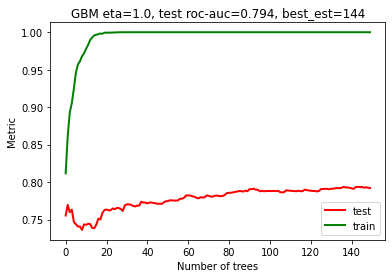

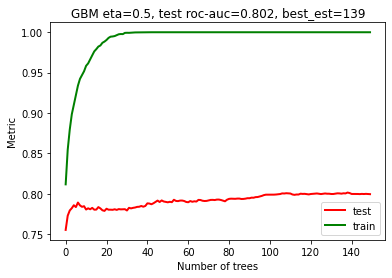

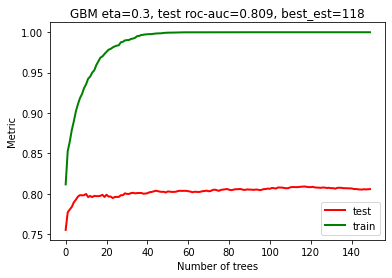

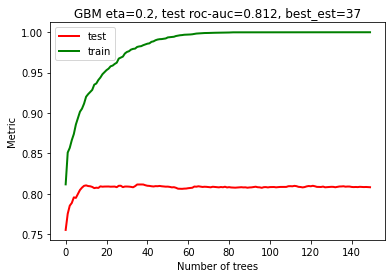

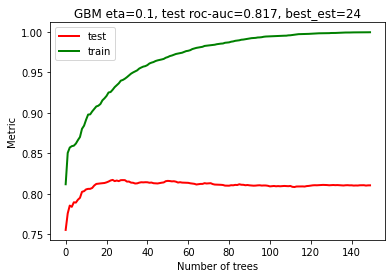

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
#Задаем разную скорость обучения для каждого из экспериментов
for learning_rate in [1, 0.5, 0.3, 0.2, 0.1]:
    #Создаем градиентный бустинг
    gbm = GradientBoostingClassifier(n_estimators=150, learning_rate=learning_rate, random_state=241).fit(X_train, y_train)
    
    l = roc_auc_score

    #Рассчитываем предсказания отклонение тестовых данных
    test_deviance = np.zeros((gbm.n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(gbm.staged_decision_function(X_test)):
        y_pred = 1.0 / (1.0 + np.exp(-y_pred))
        test_deviance[i] = roc_auc_score(y_test, y_pred)
    
    #Рассчитываем предсказания отклонения тренировочных данных
    train_deviance = np.zeros((gbm.n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(gbm.staged_decision_function(X_train)):
        y_pred = 1.0 / (1.0 + np.exp(-y_pred))
        train_deviance[i] = roc_auc_score(y_train, y_pred)

    #Отрисовываем полученные результаты
    plt.figure()
    plt.plot(test_deviance, 'r', linewidth=2)
    plt.plot(train_deviance, 'g', linewidth=2)
    plt.legend(['test', 'train'])
    
    plt.title('GBM eta=%.1f, test roc-auc=%.3f, best_est=%d' % (learning_rate, test_deviance.max(), test_deviance.argmax()+1))
    plt.xlabel('Number of trees')
    plt.ylabel('Metric')

**Интерпретация результата:**

Как видно по графикам, лучшая композиция построена при скорости обучения (η) $= 0.1$, включает 24 базовых алгоритма и достигает значения 0.817 на контрольной выборке. Для данной задачи неоптимально применять случайный лес. Случайный лес с таким же количеством базовых алгоритмов уступает градиентному бустингу, поскольку тот использует глубокие деревья, требующие вычислительных мощностей для их обучения.


**Задание для самостоятельной работы:**

Прогнозирование того, превышает ли ежегодная заработная размера 50.000$.

Описание структуры данных и csv-данные для скачивания можно найти [здесь](https://archive.ics.uci.edu/ml/datasets/Adult).